In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
tqdm.pandas()

import pickle
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['embeddings', 'embeddings.zip', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# Preprocessing
Based on https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

In [4]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print(f"Train shape: {train.shape}")
print(f"Test shape:  {test.shape}")

Train shape: (1306122, 3)
Test shape:  (56370, 2)


In [27]:
train, validation = train_test_split(train, test_size=0.08, random_state=20190101)

embed_size = 300 #word vector sizes
vocab_size = 95000 # words in vocabulary
maxlen = 100 # max words to use per question

## fill up the missing values
train_X = train["question_text"].fillna("_##_").values
val_X = validation["question_text"].fillna("_##_").values
test_X = test["question_text"].fillna("_##_").values

# Use TensorFlow tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad sentences
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the response
train_y = train['target'].values
val_y = validation['target'].values

setting up embeddings

In [6]:
EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt' 
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32') 
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8"))

In [7]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

In [7]:
word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [8]:
with open('embedding_matrix.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('embedding_matrix.pickle', 'rb') as handle:
     embedding_matrix = pickle.load(handle)

# EDA

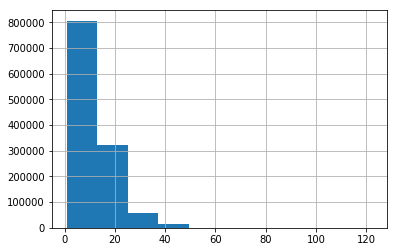

In [37]:
train['question_text'].map(lambda x: len(x.split(' '))).hist()




# Building
based on https://www.kaggle.com/shujian/different-embeddings-with-attention-fork-fork/notebook

In [9]:
hidden_layer_size = 100
BATCH_SIZE = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# should be batchsize x question length x vocab_size
# using None instead of batch size allows us to use variable batch sizes
X = tf.placeholder(tf.int32, [None, maxlen], name='X')
# 1d vector with size = None because we want to predict one val for each q, but want variable batch sizes
Y = tf.placeholder(tf.float32, [None], name='Y')
batch_size = tf.placeholder(tf.int64)

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).repeat()
iterator = dataset.make_initializable_iterator()
questions, labels = iterator.get_next()

embeddings = tf.get_variable(name="embeddings", shape=embedding_matrix.shape,
                             initializer=tf.constant_initializer(np.array(embedding_matrix)), 
                             trainable=False)
embed = tf.nn.embedding_lookup(embeddings, questions)

'''
gru_cell_1 = tf.contrib.rnn.GRUCell(hidden_layer_size)
gru_cell_2 = tf.contrib.rnn.GRUCell(hidden_layer_size)

#state tuple=true  let's us access part of the cell state later
multi_lstm_cells = tf.contrib.rnn.MultiRNNCell(cells=[gru_cell_1, gru_cell_2] , state_is_tuple=True) 

# define the operation that runs the LSTM, across time, on the data
_, final_state = tf.nn.dynamic_rnn(multi_lstm_cells, embed, dtype=tf.float32)

#FLAT = tf.layers.flatten(final_state[-1])
last_layer = tf.layers.dense(final_state[-1], 1)
classification = tf.nn.sigmoid(last_layer)
classification = tf.squeeze(classification, [1])
'''

#'''
lstm_cell_1 = tf.contrib.rnn.LSTMCell(hidden_layer_size)

# define the operation that runs the LSTM, across time, on the data
_, final_state = tf.nn.dynamic_rnn(lstm_cell_1, embed, dtype=tf.float32)

#classification = linear(final_state[-1][-1], 1, name="output")
FLAT = tf.layers.flatten(final_state.h)
last_layer = tf.layers.dense(FLAT, 1)
classification = tf.nn.sigmoid(last_layer)
classification = tf.squeeze(classification, [1])
#'''

In [10]:
# define cross entropy loss function
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.squeeze(last_layer), labels=labels)
loss = tf.reduce_mean(loss)

# define our optimizer to minimize the loss
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [11]:
# to get actual results like 'positive' or 'negative' , 
# we round the prediction probability to 0 or 1.
prediction = tf.to_float(tf.greater_equal(classification, 0.5))

with tf.name_scope('metrics'):
    F1, f1_update = tf.contrib.metrics.f1_score(labels=labels, predictions=classification, name='my_metric')

In [12]:
running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="my_metric")
reset_op = tf.variables_initializer(var_list=running_vars)

In [14]:
seed = 3

saver = tf.train.Saver()
# Start the session to compute the tensorflow graph

sess = tf.Session()
# Run the initialization
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

costs, f1 = [], []

In [23]:
# initialize iterator with train data
sess.run(iterator.initializer, feed_dict={X:train_X, Y:train_y, batch_size:BATCH_SIZE})
num_epochs = 10000
model_dir = './model-v2'

# Do the training loop
for epoch in range(51, num_epochs+1):
    batch_cost = 0.
    num_batches = 2000 #int(train_X.shape[0] / BATCH_SIZE) # number of minibatches of size minibatch_size in the train set
    seed += seed
    tf.set_random_seed(seed)

    for _ in range(num_batches):
        _ , batch_loss, _ = sess.run([optimizer, loss, f1_update])
        batch_cost += batch_loss / num_batches
        #batch_f1.append(f1_temp)
        
    #f1.append(len(batch_f1)/sum(1.0 / b for b in batch_f1 if b!=0))
    cur_f1 = sess.run(F1)
    sess.run(reset_op)
    f1.append(cur_f1)
    costs.append(batch_cost)
    print (f"Epoch {epoch} cost: {batch_cost}")
    print (f"Epoch {epoch} f1: {cur_f1}")
    saver.save(sess, f'{model_dir}/model-epoch{epoch}.ckpt')
    info = {'f1':f1, 'costs':costs, 'epoch':epoch}
    with open(f'{model_dir}/model_info.pickle', 'wb') as handle:
        pickle.dump(info, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 51 cost: 0.003108343898469911
Epoch 51 f1: 0.7424188852310181
Epoch 52 cost: 0.002289675641489336
Epoch 52 f1: 0.7470362186431885
Epoch 53 cost: 0.0037500818236176595
Epoch 53 f1: 0.7513944506645203
Epoch 54 cost: 0.002202735322923898
Epoch 54 f1: 0.7556847929954529
Epoch 55 cost: 0.003935710475385863
Epoch 55 f1: 0.7597525119781494
Epoch 56 cost: 0.0017356867771684962
Epoch 56 f1: 0.7637895941734314
Epoch 57 cost: 0.000530991074679492
Epoch 57 f1: 0.7677692770957947
Epoch 58 cost: 0.004121379527620144
Epoch 58 f1: 0.7714137434959412
Epoch 59 cost: 0.0026837825747661518
Epoch 59 f1: 0.7750465273857117
Epoch 60 cost: 0.0018989632838769255
Epoch 60 f1: 0.7785618901252747
Epoch 61 cost: 0.001303809736321225
Epoch 61 f1: 0.7820006608963013
Epoch 62 cost: 0.0029877021533832246
Epoch 62 f1: 0.7852473855018616
Epoch 63 cost: 0.002230185223870738
Epoch 63 f1: 0.7884467244148254
Epoch 64 cost: 0.0015623301729542926
Epoch 64 f1: 0.7915903925895691
Epoch 65 cost: 0.0018296178478539964
Epoch

Epoch 167 f1: 0.9185482859611511
Epoch 168 cost: 1.199365466332452e-10
Epoch 168 f1: 0.9190348982810974
Epoch 169 cost: 1.149916067394209e-10
Epoch 169 f1: 0.9195136427879333
Epoch 170 cost: 1.1460393264124947e-10
Epoch 170 f1: 0.919990062713623
Epoch 171 cost: 1.1114745846851114e-10
Epoch 171 f1: 0.9204568266868591
Epoch 172 cost: 1.0901645195017252e-10
Epoch 172 f1: 0.920918345451355
Epoch 173 cost: 1.1002076012605266e-10
Epoch 173 f1: 0.9213770031929016
Epoch 174 cost: 1.0626000022398352e-10
Epoch 174 f1: 0.92182856798172
Epoch 175 cost: 1.0304158732923513e-10
Epoch 175 f1: 0.9222767949104309
Epoch 176 cost: 1.0262823708898321e-10
Epoch 176 f1: 0.9227185845375061
Epoch 177 cost: 1.025915633502087e-10
Epoch 177 f1: 0.9231569170951843
Epoch 178 cost: 9.93560237907252e-11
Epoch 178 f1: 0.9235886931419373
Epoch 179 cost: 9.855711860162751e-11
Epoch 179 f1: 0.9240179657936096
Epoch 180 cost: 9.557790994175692e-11
Epoch 180 f1: 0.9244381189346313
Epoch 181 cost: 9.488135157745672e-11
Epoc

Epoch 282 f1: 0.9517903923988342
Epoch 283 cost: 3.6658662870322847e-11
Epoch 283 f1: 0.9519602656364441
Epoch 284 cost: 3.7987709303735524e-11
Epoch 284 f1: 0.9521308541297913
Epoch 285 cost: 3.634834051332108e-11
Epoch 285 f1: 0.9522985219955444


KeyboardInterrupt: 

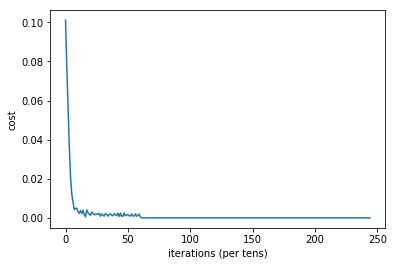

In [24]:
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
#plt.title("Learning rate =" + str(learning_rate))
plt.show()

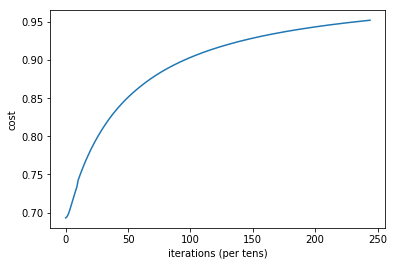

In [25]:
# plot the cost
plt.plot(np.squeeze(f1))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
#plt.title("Learning rate =" + str(learning_rate))
plt.show()

In [28]:
sess.run(iterator.initializer, feed_dict={X: val_X, Y: val_y, batch_size: 64})
sess.run(reset_op)
val_cost = 0.
num_batches = int(val_X.shape[0] / BATCH_SIZE) # number of minibatches of size minibatch_size in the train set
tf.set_random_seed(2018)

for _ in range(num_batches):
    batch_loss, _ = sess.run([loss, f1_update])
    val_cost += batch_loss / num_batches

print (f"Validation cost: {val_cost}")
print (f"Validation f1: {sess.run(F1)}")

Validation cost: 2.5251167601696327
Validation f1: 0.9508321285247803
